In [1]:
# pip install stable-baselines3

In [2]:
 # pip install prettytable

In [3]:
# pip install shimmy>=0.2.1

In [4]:
# pip install --upgrade scipy

In [5]:
# pip install tensorboard

In [6]:
# pip install pygame

## Environment initialisation

In [7]:
from RWGE import WheatGrowthEnv  # Import your custom environment

# Function to create and return an instance of your custom environment
env = WheatGrowthEnv(start_day=1, start_month=4, end_day=1, end_month=4, render_mode='human')

# Access the observation space and action space
observation_space = env.observation_space
action_space = env.action_space

print("", observation_space.shape)

# Now you can use your_observation_space and your_action_space as needed
print("Observation Space:", observation_space)
print("Action Space:", action_space)

 None
Observation Space: Dict('PS': Box(0.0, 11.0, (1,), float32), 'accumulated_excess': Box(0.0, 1000.0, (1,), float32), 'accumulated_gdd': Box(0.0, 3000.0, (1,), float32), 'accumulated_scarcity': Box(0.0, 1000.0, (1,), float32), 'current_day': Discrete(365), 'current_month': Discrete(12), 'current_month_day': Discrete(31), 'current_year': Discrete(3000), 'daily_temperature': Box(0.0, 50.0, (1,), float32), 'etc': Box(0.0, 2.0, (1,), float32), 'growth_stage': Box(0.0, 13.0, (1,), float32), 'harvest': Box(0.0, 100.0, (1,), float32), 'humidity': Box(0.0, 100.0, (1,), float32), 'is_cloudy': Discrete(2), 'is_crop_sick': Discrete(2), 'is_raining': Discrete(2), 'qv2m': Box(0.0, 11.0, (1,), float32), 'rainfall': Box(0.0, 11.0, (1,), float32), 'rn_daily': Box(0.0, 1.0, (1,), float32), 'sky_clearness': Box(0.0, 1.0, (1,), float32), 'soil_moisture_content': Box(0.0, 100.0, (1,), float32), 'water_needs': Box(0.0, 11.0, (1,), float32), 'wind_speed': Box(0.0, 11.0, (1,), float32))
Action Space: Box

In [8]:
import numpy as np
import random

# the action space is Box(low=0, high=11, shape=(1,), dtype=float)
# Create an array of different actions
possible_actions = [np.array([action]) for action in np.linspace(0, 10, num=5)]  # Example actions
env.reset()
# Run a loop to step through the environment
for _ in range(10):
    # Select a random action from the possible actions
    action = random.choice(possible_actions)
    observation, reward, done, info = env.step(action)

    #env.render(mode='human')  # Call render after each step

    # Reset the environment if done
    if done:
        observation = env.reset()

## Models declaration

In [9]:
from stable_baselines3 import SAC
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np

### Soft Actor-Critic (SAC)

In [10]:
model_sac = SAC("MultiInputPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [11]:
# Define the number of actions based on the action space
n_actions = env.action_space.shape[-1]
print(n_actions)
# Adjusting exploration noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))
print(action_noise)
# Create SAC model with exploration noise
model_sac_exp = SAC("MultiInputPolicy", env, action_noise=action_noise, verbose=1)

1
NormalActionNoise(mu=[0.], sigma=[0.2])
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\ProgramData\Anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [12]:
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import BaseCallback
import time
import numpy as np

class ActionLoggerCallback(BaseCallback):
    def __init__(self, log_path, verbose=0):
        super(ActionLoggerCallback, self).__init__(verbose)
        self.log_path = log_path
        self.actions = []

    def _on_step(self) -> bool:
        if "action" in self.locals:
            action = self.locals["action"]
            self.actions.append(action)
        return True

    def _on_training_end(self) -> None:
        np.save(f"{self.log_path}/actions.npy", np.array(self.actions))

##  Training Models

In [13]:
from stable_baselines3.common.logger import configure
import time

def train_model(model, total_timesteps, log_path):
    logger = configure(log_path, ["stdout", "csv", "tensorboard"])
    model.set_logger(logger)
    action_logger = ActionLoggerCallback(log_path=log_path)
    model.learn(total_timesteps=total_timesteps, callback=action_logger)
    model.save(f"{log_path}/final_model")
    

# Define log paths for each model
log_path_sac = "./logs/sac"

log_path_sac_exp = "./logs/sac_exp"

# Train each model
start_time_sac = time.time()
train_model(model_sac, 39080, log_path_sac)
end_time_sac = time.time()
training_time_sac = end_time_sac - start_time_sac
print(f'Training time for model_sac: {training_time_sac} seconds')

start_time_sac_exp = time.time()
train_model(model_sac_exp, 39080, log_path_sac_exp)
end_time_sac_exp = time.time()
training_time_sac_exp = end_time_sac_exp - start_time_sac_exp
print(f'Training time for model_sac_exp: {training_time_sac_exp} seconds')

Logging to ./logs/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -14.4    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 88       |
|    time_elapsed    | 0        |
|    total_timesteps | 78       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -16.1    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 18       |
|    time_elapsed    | 8        |
|    total_timesteps | 156      |
| train/             |          |
|    actor_loss      | 0.212    |
|    critic_loss     | 0.0599   |
|    ent_coef        | 0.984    |
|    ent_coef_loss   | -0.0273  |
|    learning_rate   | 0.0003   |
|    n_updates       | 55       |
--------------------------

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -14.7    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 60       |
|    fps             | 8        |
|    time_elapsed    | 139      |
|    total_timesteps | 1159     |
| train/             |          |
|    actor_loss      | 1.68     |
|    critic_loss     | 0.06     |
|    ent_coef        | 0.731    |
|    ent_coef_loss   | -0.492   |
|    learning_rate   | 0.0003   |
|    n_updates       | 1058     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -14.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 64       |
|    fps             | 8        |
|    time_elapsed    | 149      |
|    total_timesteps | 1236     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -11.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 116      |
|    fps             | 8        |
|    time_elapsed    | 279      |
|    total_timesteps | 2248     |
| train/             |          |
|    actor_loss      | 2.93     |
|    critic_loss     | 0.0403   |
|    ent_coef        | 0.535    |
|    ent_coef_loss   | -0.954   |
|    learning_rate   | 0.0003   |
|    n_updates       | 2147     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -11.5    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 120      |
|    fps             | 8        |
|    time_elapsed    | 288      |
|    total_timesteps | 2325     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.38    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 172      |
|    fps             | 7        |
|    time_elapsed    | 421      |
|    total_timesteps | 3335     |
| train/             |          |
|    actor_loss      | 3.66     |
|    critic_loss     | 0.052    |
|    ent_coef        | 0.395    |
|    ent_coef_loss   | -1.07    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3234     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.15    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 176      |
|    fps             | 7        |
|    time_elapsed    | 431      |
|    total_timesteps | 3412     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -6.72    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 228      |
|    fps             | 7        |
|    time_elapsed    | 569      |
|    total_timesteps | 4433     |
| train/             |          |
|    actor_loss      | 4.11     |
|    critic_loss     | 0.0344   |
|    ent_coef        | 0.291    |
|    ent_coef_loss   | -1.42    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4332     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -6.63    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 232      |
|    fps             | 7        |
|    time_elapsed    | 579      |
|    total_timesteps | 4511     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -5.11    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 284      |
|    fps             | 7        |
|    time_elapsed    | 710      |
|    total_timesteps | 5516     |
| train/             |          |
|    actor_loss      | 4.33     |
|    critic_loss     | 0.0342   |
|    ent_coef        | 0.217    |
|    ent_coef_loss   | -1.54    |
|    learning_rate   | 0.0003   |
|    n_updates       | 5415     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.9     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 288      |
|    fps             | 7        |
|    time_elapsed    | 720      |
|    total_timesteps | 5592     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.32    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 340      |
|    fps             | 7        |
|    time_elapsed    | 851      |
|    total_timesteps | 6604     |
| train/             |          |
|    actor_loss      | 4        |
|    critic_loss     | 0.0391   |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | -1.52    |
|    learning_rate   | 0.0003   |
|    n_updates       | 6503     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.15    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 344      |
|    fps             | 7        |
|    time_elapsed    | 861      |
|    total_timesteps | 6682     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -1.51    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 396      |
|    fps             | 7        |
|    time_elapsed    | 992      |
|    total_timesteps | 7696     |
| train/             |          |
|    actor_loss      | 3.93     |
|    critic_loss     | 0.0751   |
|    ent_coef        | 0.127    |
|    ent_coef_loss   | -1.43    |
|    learning_rate   | 0.0003   |
|    n_updates       | 7595     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -1.33    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 400      |
|    fps             | 7        |
|    time_elapsed    | 1002     |
|    total_timesteps | 7773     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 0.242    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 452      |
|    fps             | 7        |
|    time_elapsed    | 1134     |
|    total_timesteps | 8808     |
| train/             |          |
|    actor_loss      | 3.62     |
|    critic_loss     | 0.0554   |
|    ent_coef        | 0.0996   |
|    ent_coef_loss   | -1.38    |
|    learning_rate   | 0.0003   |
|    n_updates       | 8707     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 0.348    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 456      |
|    fps             | 7        |
|    time_elapsed    | 1144     |
|    total_timesteps | 8886     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.14     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 508      |
|    fps             | 7        |
|    time_elapsed    | 1276     |
|    total_timesteps | 9907     |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 0.0583   |
|    ent_coef        | 0.0825   |
|    ent_coef_loss   | -0.937   |
|    learning_rate   | 0.0003   |
|    n_updates       | 9806     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.13     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 512      |
|    fps             | 7        |
|    time_elapsed    | 1286     |
|    total_timesteps | 9986     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 1.44     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 564      |
|    fps             | 7        |
|    time_elapsed    | 1422     |
|    total_timesteps | 11036    |
| train/             |          |
|    actor_loss      | 2.91     |
|    critic_loss     | 0.0624   |
|    ent_coef        | 0.073    |
|    ent_coef_loss   | -0.435   |
|    learning_rate   | 0.0003   |
|    n_updates       | 10935    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 1.38     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 568      |
|    fps             | 7        |
|    time_elapsed    | 1431     |
|    total_timesteps | 11113    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 1.58     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 620      |
|    fps             | 7        |
|    time_elapsed    | 1569     |
|    total_timesteps | 12183    |
| train/             |          |
|    actor_loss      | 2.38     |
|    critic_loss     | 0.083    |
|    ent_coef        | 0.0693   |
|    ent_coef_loss   | 0.377    |
|    learning_rate   | 0.0003   |
|    n_updates       | 12082    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 1.65     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 624      |
|    fps             | 7        |
|    time_elapsed    | 1580     |
|    total_timesteps | 12267    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 1.61     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 676      |
|    fps             | 7        |
|    time_elapsed    | 1715     |
|    total_timesteps | 13314    |
| train/             |          |
|    actor_loss      | 2.34     |
|    critic_loss     | 0.0725   |
|    ent_coef        | 0.0736   |
|    ent_coef_loss   | 0.277    |
|    learning_rate   | 0.0003   |
|    n_updates       | 13213    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 1.68     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 680      |
|    fps             | 7        |
|    time_elapsed    | 1725     |
|    total_timesteps | 13392    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 1.59     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 732      |
|    fps             | 7        |
|    time_elapsed    | 1861     |
|    total_timesteps | 14447    |
| train/             |          |
|    actor_loss      | 2.37     |
|    critic_loss     | 0.086    |
|    ent_coef        | 0.0756   |
|    ent_coef_loss   | -0.163   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14346    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 1.67     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 736      |
|    fps             | 7        |
|    time_elapsed    | 1871     |
|    total_timesteps | 14528    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 1.73     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 788      |
|    fps             | 7        |
|    time_elapsed    | 2007     |
|    total_timesteps | 15578    |
| train/             |          |
|    actor_loss      | 1.95     |
|    critic_loss     | 0.062    |
|    ent_coef        | 0.0782   |
|    ent_coef_loss   | -0.132   |
|    learning_rate   | 0.0003   |
|    n_updates       | 15477    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 1.67     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 792      |
|    fps             | 7        |
|    time_elapsed    | 2017     |
|    total_timesteps | 15657    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 1.46     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 844      |
|    fps             | 7        |
|    time_elapsed    | 2153     |
|    total_timesteps | 16711    |
| train/             |          |
|    actor_loss      | 2.2      |
|    critic_loss     | 0.0705   |
|    ent_coef        | 0.0793   |
|    ent_coef_loss   | -0.213   |
|    learning_rate   | 0.0003   |
|    n_updates       | 16610    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | 1.43     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 848      |
|    fps             | 7        |
|    time_elapsed    | 2163     |
|    total_timesteps | 16794    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 1.5      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 900      |
|    fps             | 7        |
|    time_elapsed    | 2298     |
|    total_timesteps | 17826    |
| train/             |          |
|    actor_loss      | 2.07     |
|    critic_loss     | 0.0583   |
|    ent_coef        | 0.081    |
|    ent_coef_loss   | -0.107   |
|    learning_rate   | 0.0003   |
|    n_updates       | 17725    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.1     |
|    ep_rew_mean     | 1.52     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 904      |
|    fps             | 7        |
|    time_elapsed    | 2309     |
|    total_timesteps | 17908    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.47     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 956      |
|    fps             | 7        |
|    time_elapsed    | 2441     |
|    total_timesteps | 18929    |
| train/             |          |
|    actor_loss      | 1.81     |
|    critic_loss     | 0.0696   |
|    ent_coef        | 0.0813   |
|    ent_coef_loss   | -0.122   |
|    learning_rate   | 0.0003   |
|    n_updates       | 18828    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.45     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 960      |
|    fps             | 7        |
|    time_elapsed    | 2451     |
|    total_timesteps | 19006    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.51     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1012     |
|    fps             | 7        |
|    time_elapsed    | 2583     |
|    total_timesteps | 20036    |
| train/             |          |
|    actor_loss      | 1.72     |
|    critic_loss     | 0.071    |
|    ent_coef        | 0.0817   |
|    ent_coef_loss   | -0.129   |
|    learning_rate   | 0.0003   |
|    n_updates       | 19935    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.51     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1016     |
|    fps             | 7        |
|    time_elapsed    | 2594     |
|    total_timesteps | 20115    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.56     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1068     |
|    fps             | 7        |
|    time_elapsed    | 2727     |
|    total_timesteps | 21149    |
| train/             |          |
|    actor_loss      | 2.02     |
|    critic_loss     | 0.0859   |
|    ent_coef        | 0.0848   |
|    ent_coef_loss   | -0.0269  |
|    learning_rate   | 0.0003   |
|    n_updates       | 21048    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.62     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1072     |
|    fps             | 7        |
|    time_elapsed    | 2737     |
|    total_timesteps | 21226    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 1.63     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1124     |
|    fps             | 7        |
|    time_elapsed    | 2870     |
|    total_timesteps | 22262    |
| train/             |          |
|    actor_loss      | 1.66     |
|    critic_loss     | 0.0642   |
|    ent_coef        | 0.0872   |
|    ent_coef_loss   | -0.775   |
|    learning_rate   | 0.0003   |
|    n_updates       | 22161    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 1.67     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1128     |
|    fps             | 7        |
|    time_elapsed    | 2881     |
|    total_timesteps | 22343    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 1.43     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1180     |
|    fps             | 7        |
|    time_elapsed    | 3012     |
|    total_timesteps | 23371    |
| train/             |          |
|    actor_loss      | 1.67     |
|    critic_loss     | 0.0811   |
|    ent_coef        | 0.0877   |
|    ent_coef_loss   | 0.0132   |
|    learning_rate   | 0.0003   |
|    n_updates       | 23270    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.43     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1184     |
|    fps             | 7        |
|    time_elapsed    | 3022     |
|    total_timesteps | 23449    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.2      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1236     |
|    fps             | 7        |
|    time_elapsed    | 3154     |
|    total_timesteps | 24472    |
| train/             |          |
|    actor_loss      | 1.48     |
|    critic_loss     | 0.0568   |
|    ent_coef        | 0.0913   |
|    ent_coef_loss   | -0.0639  |
|    learning_rate   | 0.0003   |
|    n_updates       | 24371    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.26     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1240     |
|    fps             | 7        |
|    time_elapsed    | 3165     |
|    total_timesteps | 24550    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.36     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1292     |
|    fps             | 7        |
|    time_elapsed    | 3297     |
|    total_timesteps | 25571    |
| train/             |          |
|    actor_loss      | 1.72     |
|    critic_loss     | 0.073    |
|    ent_coef        | 0.0903   |
|    ent_coef_loss   | 0.465    |
|    learning_rate   | 0.0003   |
|    n_updates       | 25470    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.32     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1296     |
|    fps             | 7        |
|    time_elapsed    | 3307     |
|    total_timesteps | 25653    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.54     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1348     |
|    fps             | 7        |
|    time_elapsed    | 3440     |
|    total_timesteps | 26683    |
| train/             |          |
|    actor_loss      | 1.74     |
|    critic_loss     | 0.105    |
|    ent_coef        | 0.0926   |
|    ent_coef_loss   | -0.126   |
|    learning_rate   | 0.0003   |
|    n_updates       | 26582    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.61     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1352     |
|    fps             | 7        |
|    time_elapsed    | 3450     |
|    total_timesteps | 26760    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.66     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1404     |
|    fps             | 7        |
|    time_elapsed    | 3581     |
|    total_timesteps | 27780    |
| train/             |          |
|    actor_loss      | 1.7      |
|    critic_loss     | 0.0688   |
|    ent_coef        | 0.0935   |
|    ent_coef_loss   | -0.155   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27679    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.67     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1408     |
|    fps             | 7        |
|    time_elapsed    | 3591     |
|    total_timesteps | 27857    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.41     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1460     |
|    fps             | 7        |
|    time_elapsed    | 3724     |
|    total_timesteps | 28885    |
| train/             |          |
|    actor_loss      | 1.57     |
|    critic_loss     | 0.0874   |
|    ent_coef        | 0.0956   |
|    ent_coef_loss   | -0.0441  |
|    learning_rate   | 0.0003   |
|    n_updates       | 28784    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.42     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1464     |
|    fps             | 7        |
|    time_elapsed    | 3735     |
|    total_timesteps | 28963    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.33     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1516     |
|    fps             | 7        |
|    time_elapsed    | 3868     |
|    total_timesteps | 29980    |
| train/             |          |
|    actor_loss      | 1.33     |
|    critic_loss     | 0.0849   |
|    ent_coef        | 0.0957   |
|    ent_coef_loss   | 0.282    |
|    learning_rate   | 0.0003   |
|    n_updates       | 29879    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.4      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1520     |
|    fps             | 7        |
|    time_elapsed    | 3878     |
|    total_timesteps | 30058    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.61     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1572     |
|    fps             | 7        |
|    time_elapsed    | 4011     |
|    total_timesteps | 31083    |
| train/             |          |
|    actor_loss      | 1.44     |
|    critic_loss     | 0.0981   |
|    ent_coef        | 0.0968   |
|    ent_coef_loss   | -0.287   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30982    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.59     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1576     |
|    fps             | 7        |
|    time_elapsed    | 4021     |
|    total_timesteps | 31161    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.43     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1628     |
|    fps             | 7        |
|    time_elapsed    | 4158     |
|    total_timesteps | 32182    |
| train/             |          |
|    actor_loss      | 1.77     |
|    critic_loss     | 0.0651   |
|    ent_coef        | 0.0968   |
|    ent_coef_loss   | -0.364   |
|    learning_rate   | 0.0003   |
|    n_updates       | 32081    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.41     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1632     |
|    fps             | 7        |
|    time_elapsed    | 4170     |
|    total_timesteps | 32264    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.38     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1684     |
|    fps             | 7        |
|    time_elapsed    | 4302     |
|    total_timesteps | 33286    |
| train/             |          |
|    actor_loss      | 1.53     |
|    critic_loss     | 0.0934   |
|    ent_coef        | 0.0999   |
|    ent_coef_loss   | 0.324    |
|    learning_rate   | 0.0003   |
|    n_updates       | 33185    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.35     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1688     |
|    fps             | 7        |
|    time_elapsed    | 4312     |
|    total_timesteps | 33363    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.48     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1740     |
|    fps             | 7        |
|    time_elapsed    | 4444     |
|    total_timesteps | 34388    |
| train/             |          |
|    actor_loss      | 1.55     |
|    critic_loss     | 0.0784   |
|    ent_coef        | 0.0982   |
|    ent_coef_loss   | 0.062    |
|    learning_rate   | 0.0003   |
|    n_updates       | 34287    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.48     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1744     |
|    fps             | 7        |
|    time_elapsed    | 4454     |
|    total_timesteps | 34465    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.45     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1796     |
|    fps             | 7        |
|    time_elapsed    | 4586     |
|    total_timesteps | 35482    |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     | 0.0841   |
|    ent_coef        | 0.0996   |
|    ent_coef_loss   | 0.0679   |
|    learning_rate   | 0.0003   |
|    n_updates       | 35381    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 1.46     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1800     |
|    fps             | 7        |
|    time_elapsed    | 4596     |
|    total_timesteps | 35563    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.49     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1852     |
|    fps             | 7        |
|    time_elapsed    | 4730     |
|    total_timesteps | 36598    |
| train/             |          |
|    actor_loss      | 1.4      |
|    critic_loss     | 0.0585   |
|    ent_coef        | 0.101    |
|    ent_coef_loss   | -0.282   |
|    learning_rate   | 0.0003   |
|    n_updates       | 36497    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.54     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1856     |
|    fps             | 7        |
|    time_elapsed    | 4740     |
|    total_timesteps | 36678    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.8     |
|    ep_rew_mean     | 1.58     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1908     |
|    fps             | 7        |
|    time_elapsed    | 4872     |
|    total_timesteps | 37702    |
| train/             |          |
|    actor_loss      | 1.81     |
|    critic_loss     | 0.0718   |
|    ent_coef        | 0.101    |
|    ent_coef_loss   | 0.0605   |
|    learning_rate   | 0.0003   |
|    n_updates       | 37601    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.9     |
|    ep_rew_mean     | 1.57     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1912     |
|    fps             | 7        |
|    time_elapsed    | 4882     |
|    total_timesteps | 37785    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.27     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1964     |
|    fps             | 7        |
|    time_elapsed    | 5014     |
|    total_timesteps | 38807    |
| train/             |          |
|    actor_loss      | 1.62     |
|    critic_loss     | 0.0488   |
|    ent_coef        | 0.101    |
|    ent_coef_loss   | -0.352   |
|    learning_rate   | 0.0003   |
|    n_updates       | 38706    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 1.25     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1968     |
|    fps             | 7        |
|    time_elapsed    | 5024     |
|    total_timesteps | 38886    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | -15.8    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 44       |
|    fps             | 8        |
|    time_elapsed    | 97       |
|    total_timesteps | 868      |
| train/             |          |
|    actor_loss      | 0.503    |
|    critic_loss     | 0.0549   |
|    ent_coef        | 0.794    |
|    ent_coef_loss   | -0.382   |
|    learning_rate   | 0.0003   |
|    n_updates       | 767      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | -15.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 48       |
|    fps             | 8        |
|    time_elapsed    | 107      |
|    total_timesteps | 945      |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -12.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 100      |
|    fps             | 8        |
|    time_elapsed    | 236      |
|    total_timesteps | 1960     |
| train/             |          |
|    actor_loss      | 2.14     |
|    critic_loss     | 0.0442   |
|    ent_coef        | 0.578    |
|    ent_coef_loss   | -0.748   |
|    learning_rate   | 0.0003   |
|    n_updates       | 1859     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -12.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 104      |
|    fps             | 8        |
|    time_elapsed    | 246      |
|    total_timesteps | 2036     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -8.95    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 156      |
|    fps             | 8        |
|    time_elapsed    | 375      |
|    total_timesteps | 3045     |
| train/             |          |
|    actor_loss      | 3.44     |
|    critic_loss     | 0.0298   |
|    ent_coef        | 0.427    |
|    ent_coef_loss   | -1.14    |
|    learning_rate   | 0.0003   |
|    n_updates       | 2944     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -8.81    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 160      |
|    fps             | 8        |
|    time_elapsed    | 385      |
|    total_timesteps | 3121     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -7.37    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 212      |
|    fps             | 8        |
|    time_elapsed    | 512      |
|    total_timesteps | 4123     |
| train/             |          |
|    actor_loss      | 3.89     |
|    critic_loss     | 0.0556   |
|    ent_coef        | 0.317    |
|    ent_coef_loss   | -1.49    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4022     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -7.38    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 216      |
|    fps             | 8        |
|    time_elapsed    | 522      |
|    total_timesteps | 4201     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -6.57    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 268      |
|    fps             | 8        |
|    time_elapsed    | 651      |
|    total_timesteps | 5216     |
| train/             |          |
|    actor_loss      | 4.26     |
|    critic_loss     | 0.0507   |
|    ent_coef        | 0.235    |
|    ent_coef_loss   | -1.49    |
|    learning_rate   | 0.0003   |
|    n_updates       | 5115     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -6.57    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 272      |
|    fps             | 8        |
|    time_elapsed    | 661      |
|    total_timesteps | 5295     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -5.92    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 324      |
|    fps             | 7        |
|    time_elapsed    | 790      |
|    total_timesteps | 6301     |
| train/             |          |
|    actor_loss      | 4.27     |
|    critic_loss     | 0.034    |
|    ent_coef        | 0.176    |
|    ent_coef_loss   | -1.67    |
|    learning_rate   | 0.0003   |
|    n_updates       | 6200     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -5.89    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 328      |
|    fps             | 7        |
|    time_elapsed    | 800      |
|    total_timesteps | 6379     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -5.37    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 380      |
|    fps             | 7        |
|    time_elapsed    | 931      |
|    total_timesteps | 7397     |
| train/             |          |
|    actor_loss      | 4.2      |
|    critic_loss     | 0.056    |
|    ent_coef        | 0.133    |
|    ent_coef_loss   | -1.42    |
|    learning_rate   | 0.0003   |
|    n_updates       | 7296     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -5.35    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 384      |
|    fps             | 7        |
|    time_elapsed    | 942      |
|    total_timesteps | 7476     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.63    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 436      |
|    fps             | 7        |
|    time_elapsed    | 1071     |
|    total_timesteps | 8486     |
| train/             |          |
|    actor_loss      | 4.27     |
|    critic_loss     | 0.0477   |
|    ent_coef        | 0.102    |
|    ent_coef_loss   | -1.61    |
|    learning_rate   | 0.0003   |
|    n_updates       | 8385     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.54    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 440      |
|    fps             | 7        |
|    time_elapsed    | 1081     |
|    total_timesteps | 8563     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -4.25    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 492      |
|    fps             | 7        |
|    time_elapsed    | 1209     |
|    total_timesteps | 9566     |
| train/             |          |
|    actor_loss      | 4.12     |
|    critic_loss     | 0.0799   |
|    ent_coef        | 0.0793   |
|    ent_coef_loss   | -1.02    |
|    learning_rate   | 0.0003   |
|    n_updates       | 9465     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -4.26    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 496      |
|    fps             | 7        |
|    time_elapsed    | 1219     |
|    total_timesteps | 9646     |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.3     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 548      |
|    fps             | 7        |
|    time_elapsed    | 1350     |
|    total_timesteps | 10658    |
| train/             |          |
|    actor_loss      | 4.16     |
|    critic_loss     | 0.0497   |
|    ent_coef        | 0.063    |
|    ent_coef_loss   | -1.16    |
|    learning_rate   | 0.0003   |
|    n_updates       | 10557    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.32    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 552      |
|    fps             | 7        |
|    time_elapsed    | 1360     |
|    total_timesteps | 10736    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.23    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 604      |
|    fps             | 7        |
|    time_elapsed    | 1489     |
|    total_timesteps | 11752    |
| train/             |          |
|    actor_loss      | 4.02     |
|    critic_loss     | 0.0398   |
|    ent_coef        | 0.0517   |
|    ent_coef_loss   | -1.26    |
|    learning_rate   | 0.0003   |
|    n_updates       | 11651    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -4.25    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 608      |
|    fps             | 7        |
|    time_elapsed    | 1499     |
|    total_timesteps | 11830    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.17    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 660      |
|    fps             | 7        |
|    time_elapsed    | 1627     |
|    total_timesteps | 12833    |
| train/             |          |
|    actor_loss      | 3.79     |
|    critic_loss     | 0.062    |
|    ent_coef        | 0.0446   |
|    ent_coef_loss   | -0.651   |
|    learning_rate   | 0.0003   |
|    n_updates       | 12732    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.23    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 664      |
|    fps             | 7        |
|    time_elapsed    | 1637     |
|    total_timesteps | 12912    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.11    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 716      |
|    fps             | 7        |
|    time_elapsed    | 1768     |
|    total_timesteps | 13923    |
| train/             |          |
|    actor_loss      | 3.61     |
|    critic_loss     | 0.0625   |
|    ent_coef        | 0.0411   |
|    ent_coef_loss   | 0.378    |
|    learning_rate   | 0.0003   |
|    n_updates       | 13822    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.04    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 720      |
|    fps             | 7        |
|    time_elapsed    | 1778     |
|    total_timesteps | 14003    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -3.85    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 772      |
|    fps             | 7        |
|    time_elapsed    | 1909     |
|    total_timesteps | 15025    |
| train/             |          |
|    actor_loss      | 3.75     |
|    critic_loss     | 0.0345   |
|    ent_coef        | 0.0407   |
|    ent_coef_loss   | -0.219   |
|    learning_rate   | 0.0003   |
|    n_updates       | 14924    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -3.87    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 776      |
|    fps             | 7        |
|    time_elapsed    | 1919     |
|    total_timesteps | 15106    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -4.17    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 828      |
|    fps             | 7        |
|    time_elapsed    | 2049     |
|    total_timesteps | 16121    |
| train/             |          |
|    actor_loss      | 3.51     |
|    critic_loss     | 0.0564   |
|    ent_coef        | 0.0428   |
|    ent_coef_loss   | -0.0182  |
|    learning_rate   | 0.0003   |
|    n_updates       | 16020    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | -4.21    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 832      |
|    fps             | 7        |
|    time_elapsed    | 2060     |
|    total_timesteps | 16202    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.13    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 884      |
|    fps             | 7        |
|    time_elapsed    | 2189     |
|    total_timesteps | 17213    |
| train/             |          |
|    actor_loss      | 3.32     |
|    critic_loss     | 0.0668   |
|    ent_coef        | 0.0438   |
|    ent_coef_loss   | 0.121    |
|    learning_rate   | 0.0003   |
|    n_updates       | 17112    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.1     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 888      |
|    fps             | 7        |
|    time_elapsed    | 2200     |
|    total_timesteps | 17294    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.03    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 940      |
|    fps             | 7        |
|    time_elapsed    | 2331     |
|    total_timesteps | 18303    |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 0.0754   |
|    ent_coef        | 0.0444   |
|    ent_coef_loss   | -0.0975  |
|    learning_rate   | 0.0003   |
|    n_updates       | 18202    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.08    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 944      |
|    fps             | 7        |
|    time_elapsed    | 2341     |
|    total_timesteps | 18381    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.14    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 996      |
|    fps             | 7        |
|    time_elapsed    | 2470     |
|    total_timesteps | 19388    |
| train/             |          |
|    actor_loss      | 3.55     |
|    critic_loss     | 0.0916   |
|    ent_coef        | 0.0455   |
|    ent_coef_loss   | 0.103    |
|    learning_rate   | 0.0003   |
|    n_updates       | 19287    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.09    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 7        |
|    time_elapsed    | 2480     |
|    total_timesteps | 19466    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -3.92    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1052     |
|    fps             | 7        |
|    time_elapsed    | 2614     |
|    total_timesteps | 20470    |
| train/             |          |
|    actor_loss      | 3.64     |
|    critic_loss     | 0.0469   |
|    ent_coef        | 0.0462   |
|    ent_coef_loss   | 0.139    |
|    learning_rate   | 0.0003   |
|    n_updates       | 20369    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4       |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1056     |
|    fps             | 7        |
|    time_elapsed    | 2625     |
|    total_timesteps | 20549    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.92    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1108     |
|    fps             | 7        |
|    time_elapsed    | 2774     |
|    total_timesteps | 21558    |
| train/             |          |
|    actor_loss      | 3.36     |
|    critic_loss     | 0.0518   |
|    ent_coef        | 0.0473   |
|    ent_coef_loss   | 0.136    |
|    learning_rate   | 0.0003   |
|    n_updates       | 21457    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.9     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1112     |
|    fps             | 7        |
|    time_elapsed    | 2785     |
|    total_timesteps | 21639    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.01    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1164     |
|    fps             | 7        |
|    time_elapsed    | 2916     |
|    total_timesteps | 22655    |
| train/             |          |
|    actor_loss      | 3.47     |
|    critic_loss     | 0.0484   |
|    ent_coef        | 0.0479   |
|    ent_coef_loss   | -0.193   |
|    learning_rate   | 0.0003   |
|    n_updates       | 22554    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.02    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1168     |
|    fps             | 7        |
|    time_elapsed    | 2926     |
|    total_timesteps | 22734    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.09    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1220     |
|    fps             | 7        |
|    time_elapsed    | 3055     |
|    total_timesteps | 23741    |
| train/             |          |
|    actor_loss      | 3.33     |
|    critic_loss     | 0.0846   |
|    ent_coef        | 0.0495   |
|    ent_coef_loss   | 0.183    |
|    learning_rate   | 0.0003   |
|    n_updates       | 23640    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.05    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1224     |
|    fps             | 7        |
|    time_elapsed    | 3066     |
|    total_timesteps | 23821    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -4.32    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1276     |
|    fps             | 7        |
|    time_elapsed    | 3194     |
|    total_timesteps | 24823    |
| train/             |          |
|    actor_loss      | 3.5      |
|    critic_loss     | 0.069    |
|    ent_coef        | 0.0487   |
|    ent_coef_loss   | 0.292    |
|    learning_rate   | 0.0003   |
|    n_updates       | 24722    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.28    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1280     |
|    fps             | 7        |
|    time_elapsed    | 3205     |
|    total_timesteps | 24901    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.03    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1332     |
|    fps             | 7        |
|    time_elapsed    | 3335     |
|    total_timesteps | 25912    |
| train/             |          |
|    actor_loss      | 3.33     |
|    critic_loss     | 0.0583   |
|    ent_coef        | 0.0493   |
|    ent_coef_loss   | -0.175   |
|    learning_rate   | 0.0003   |
|    n_updates       | 25811    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -3.97    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1336     |
|    fps             | 7        |
|    time_elapsed    | 3345     |
|    total_timesteps | 25989    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.06    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1388     |
|    fps             | 7        |
|    time_elapsed    | 3475     |
|    total_timesteps | 27004    |
| train/             |          |
|    actor_loss      | 3.19     |
|    critic_loss     | 0.0633   |
|    ent_coef        | 0.0495   |
|    ent_coef_loss   | 0.16     |
|    learning_rate   | 0.0003   |
|    n_updates       | 26903    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.07    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1392     |
|    fps             | 7        |
|    time_elapsed    | 3484     |
|    total_timesteps | 27081    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -3.94    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1444     |
|    fps             | 7        |
|    time_elapsed    | 3613     |
|    total_timesteps | 28079    |
| train/             |          |
|    actor_loss      | 3.35     |
|    critic_loss     | 0.0512   |
|    ent_coef        | 0.0505   |
|    ent_coef_loss   | -0.0908  |
|    learning_rate   | 0.0003   |
|    n_updates       | 27978    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | -3.92    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1448     |
|    fps             | 7        |
|    time_elapsed    | 3623     |
|    total_timesteps | 28156    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.01    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1500     |
|    fps             | 7        |
|    time_elapsed    | 3754     |
|    total_timesteps | 29171    |
| train/             |          |
|    actor_loss      | 3.25     |
|    critic_loss     | 0.0878   |
|    ent_coef        | 0.0511   |
|    ent_coef_loss   | 0.361    |
|    learning_rate   | 0.0003   |
|    n_updates       | 29070    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -4.03    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1504     |
|    fps             | 7        |
|    time_elapsed    | 3764     |
|    total_timesteps | 29250    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -3.88    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1556     |
|    fps             | 7        |
|    time_elapsed    | 3894     |
|    total_timesteps | 30260    |
| train/             |          |
|    actor_loss      | 3.24     |
|    critic_loss     | 0.0585   |
|    ent_coef        | 0.0514   |
|    ent_coef_loss   | -0.453   |
|    learning_rate   | 0.0003   |
|    n_updates       | 30159    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.87    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1560     |
|    fps             | 7        |
|    time_elapsed    | 3904     |
|    total_timesteps | 30337    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.91    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1612     |
|    fps             | 7        |
|    time_elapsed    | 4034     |
|    total_timesteps | 31345    |
| train/             |          |
|    actor_loss      | 3.3      |
|    critic_loss     | 0.0558   |
|    ent_coef        | 0.052    |
|    ent_coef_loss   | 0.254    |
|    learning_rate   | 0.0003   |
|    n_updates       | 31244    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.92    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1616     |
|    fps             | 7        |
|    time_elapsed    | 4043     |
|    total_timesteps | 31421    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.91    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1668     |
|    fps             | 7        |
|    time_elapsed    | 4173     |
|    total_timesteps | 32429    |
| train/             |          |
|    actor_loss      | 3.47     |
|    critic_loss     | 0.054    |
|    ent_coef        | 0.052    |
|    ent_coef_loss   | 0.0568   |
|    learning_rate   | 0.0003   |
|    n_updates       | 32328    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.89    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1672     |
|    fps             | 7        |
|    time_elapsed    | 4183     |
|    total_timesteps | 32510    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.03    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1724     |
|    fps             | 7        |
|    time_elapsed    | 4312     |
|    total_timesteps | 33527    |
| train/             |          |
|    actor_loss      | 3.27     |
|    critic_loss     | 0.0387   |
|    ent_coef        | 0.0535   |
|    ent_coef_loss   | -0.208   |
|    learning_rate   | 0.0003   |
|    n_updates       | 33426    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -3.97    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1728     |
|    fps             | 7        |
|    time_elapsed    | 4323     |
|    total_timesteps | 33605    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.18    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1780     |
|    fps             | 7        |
|    time_elapsed    | 4453     |
|    total_timesteps | 34613    |
| train/             |          |
|    actor_loss      | 3.21     |
|    critic_loss     | 0.0601   |
|    ent_coef        | 0.0542   |
|    ent_coef_loss   | -0.146   |
|    learning_rate   | 0.0003   |
|    n_updates       | 34512    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.17    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1784     |
|    fps             | 7        |
|    time_elapsed    | 4463     |
|    total_timesteps | 34692    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.17    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1836     |
|    fps             | 7        |
|    time_elapsed    | 4594     |
|    total_timesteps | 35711    |
| train/             |          |
|    actor_loss      | 3.39     |
|    critic_loss     | 0.0642   |
|    ent_coef        | 0.0539   |
|    ent_coef_loss   | -0.117   |
|    learning_rate   | 0.0003   |
|    n_updates       | 35610    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.27    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1840     |
|    fps             | 7        |
|    time_elapsed    | 4604     |
|    total_timesteps | 35791    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -3.97    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1892     |
|    fps             | 7        |
|    time_elapsed    | 4733     |
|    total_timesteps | 36798    |
| train/             |          |
|    actor_loss      | 3.31     |
|    critic_loss     | 0.0538   |
|    ent_coef        | 0.0544   |
|    ent_coef_loss   | 0.0682   |
|    learning_rate   | 0.0003   |
|    n_updates       | 36697    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.01    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1896     |
|    fps             | 7        |
|    time_elapsed    | 4743     |
|    total_timesteps | 36876    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.94    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1948     |
|    fps             | 7        |
|    time_elapsed    | 4873     |
|    total_timesteps | 37886    |
| train/             |          |
|    actor_loss      | 3.11     |
|    critic_loss     | 0.0587   |
|    ent_coef        | 0.0551   |
|    ent_coef_loss   | 0.124    |
|    learning_rate   | 0.0003   |
|    n_updates       | 37785    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | -3.98    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 1952     |
|    fps             | 7        |
|    time_elapsed    | 4883     |
|    total_timesteps | 37963    |
| train/             |          |
|    actor_los

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.1     |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 2004     |
|    fps             | 7        |
|    time_elapsed    | 5014     |
|    total_timesteps | 38977    |
| train/             |          |
|    actor_loss      | 3.17     |
|    critic_loss     | 0.0822   |
|    ent_coef        | 0.0557   |
|    ent_coef_loss   | -0.158   |
|    learning_rate   | 0.0003   |
|    n_updates       | 38876    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | -4.13    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 2008     |
|    fps             | 7        |
|    time_elapsed    | 5024     |
|    total_timesteps | 39057    |
| train/             |          |
|    actor_los

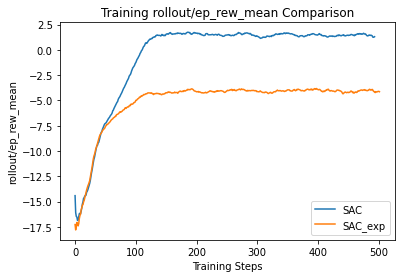

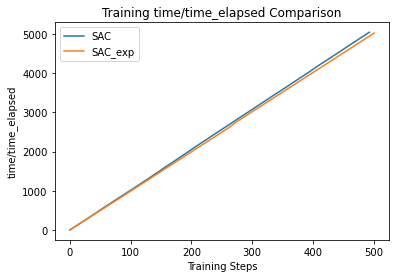

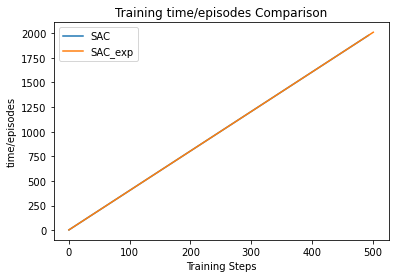

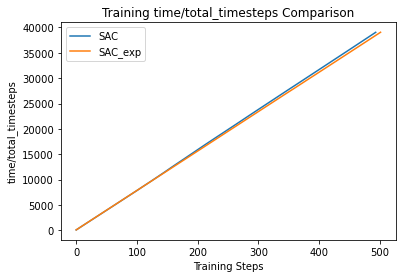

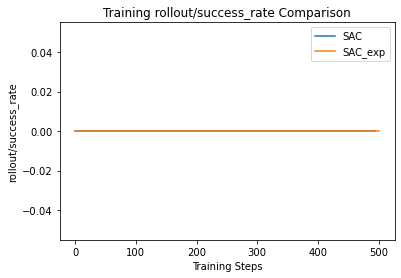

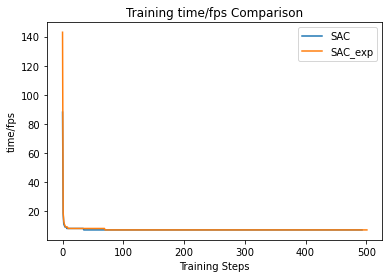

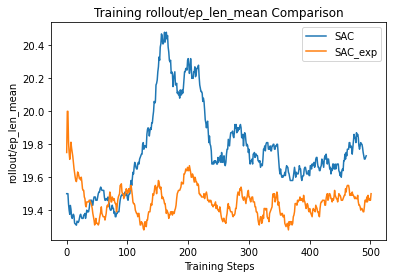

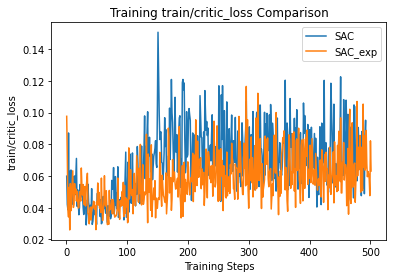

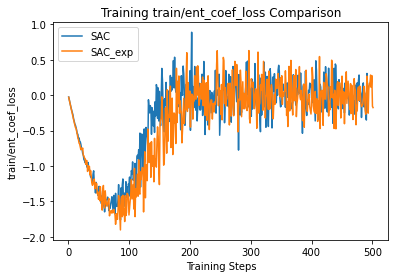

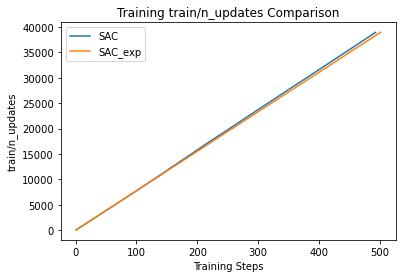

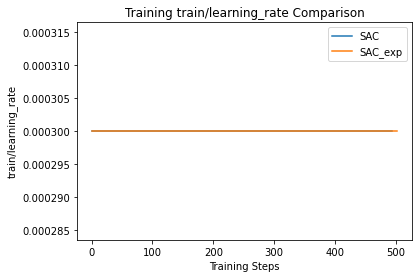

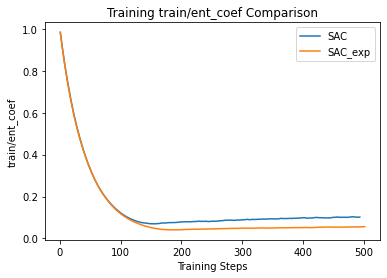

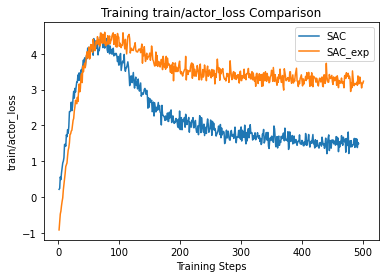

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_all_metrics(log_paths, model_names):
    # Assuming that all log files have the same structure
    example_log_file = f"{log_paths[0]}/progress.csv"
    df_example = pd.read_csv(example_log_file)

    for metric in df_example.columns:
        plt.figure()
        for log_path, model_name in zip(log_paths, model_names):
            log_file = f"{log_path}/progress.csv"
            df = pd.read_csv(log_file)
            if metric in df.columns:
                plt.plot(df[metric], label=model_name)
            else:
                print(f"Metric '{metric}' not found in {log_file}")
        plt.xlabel('Training Steps')
        plt.ylabel(metric)
        plt.legend()
        plt.title(f'Training {metric} Comparison')
        plt.show()

# Paths to your log files
log_paths = [log_path_sac,log_path_sac_exp]
model_names = ['SAC', 'SAC_exp']

# Plot all metrics
plot_all_metrics(log_paths, model_names)

## Test and evaluation of models

In [15]:
from stable_baselines3.common.evaluation import evaluate_policy

def evaluate_and_print(model, model_name):
    mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)
    print(f"Mean reward for {model_name}: {mean_reward}, Std reward: {std_reward}")

# Assuming model_ppo, model_ddpg, model_sac, and model_td3 are already defined and trained
#evaluate_and_print(model_ppo, "PPO")
evaluate_and_print(model_sac, "SAC")
evaluate_and_print(model_sac_exp, "SAC_exp")

Mean reward for SAC: 3.1342073, Std reward: 1.0434700496596967
Mean reward for SAC_exp: 2.9181684, Std reward: 1.0232059095423756


In [16]:
from stable_baselines3.common.evaluation import evaluate_policy

def evaluate_model(model, n_episodes=10):
    mean_reward, _ = evaluate_policy(model, model.get_env(), n_eval_episodes=n_episodes)
    return mean_reward

# Assuming models are defined and trained: model_ppo, model_ddpg, model_sac, model_td3
model_names = ['SAC', 'SAC_exp']
models = [model_sac, model_sac_exp]

# Evaluate each model and store results
results = {}
for model, name in zip(models, model_names):
    results[name] = evaluate_model(model, n_episodes=10)

# Determine the best model
best_model_name = max(results, key=results.get)
best_model_score = results[best_model_name]

print(f"Best Model: {best_model_name} with a mean reward of {best_model_score}")

# Optionally, print all results for comparison
for model_name, score in results.items():
    print(f"{model_name}: Mean Reward = {score}")

Best Model: SAC_exp with a mean reward of 3.1653972
SAC: Mean Reward = 2.8067974999999996
SAC_exp: Mean Reward = 3.1653972


In [17]:
def test_model(model, env, num_episodes=10):
    for episode in range(num_episodes):
        # obs, info = env.reset()
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, info = env.step(action)
            done = terminated
        print(f"Episode {episode + 1} completed, Reward {reward}")

# Assuming env is your environment and models are already trained
# Replace model_ppo, model_ddpg, model_sac, model_td3 with your model instances
test_model(model_sac, env)

ValueError: Error: Unexpected observation shape () for Box environment, please use (1,) or (n_env, 1) for the observation shape.